## Libs

In [1]:
import pandas as pd
import numpy as np 
import joblib
import sys

import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, confusion_matrix as cm
from sklearn.compose import ColumnTransformer
from fast_ml.model_development import train_valid_test_split

from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC

## Extraction

In [2]:
# path to read specific csv data
path = r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv'
# config path scripts
sys.path.insert(0, r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\scripts')

from extract_data import read_data

df = read_data(path)
df_copy = df.set_index(['customerID']).copy()
df_copy.drop(['gender','PhoneService'], inplace=True, axis=1)

## train, valid, test split

In [3]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy, target = 'Churn', train_size=0.8, valid_size=0.1, test_size=0.1)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_valid shape: ',X_valid.shape)
print('y_valid shape: ',y_valid.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5634, 17)
y_train shape:  (5634,)
X_valid shape:  (704, 17)
y_valid shape:  (704,)
X_test shape:  (705, 17)
y_test shape:  (705,)


## Feature Selection

In [4]:
num_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

In [5]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [6]:
cat_cols = df_copy.select_dtypes(include=['object']).columns.tolist()[:-1]

In [7]:
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## Create Pipeline 

In [8]:
preprocessor = ColumnTransformer(
                                transformers=[
                                ('cat', ce.BinaryEncoder(), cat_cols), 
                                ('num', MinMaxScaler(), num_cols)
                                ], remainder="passthrough")

model = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [9]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

## Training and Validate

In [10]:
# Encoder Target variables
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)
y_test = le_Y.transform(y_test)

In [11]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.783 STD: 0.08, AUC: 0.771
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       493
           1       0.56      0.82      0.66       211

    accuracy                           0.75       704
   macro avg       0.73      0.77      0.73       704
weighted avg       0.80      0.75      0.76       704



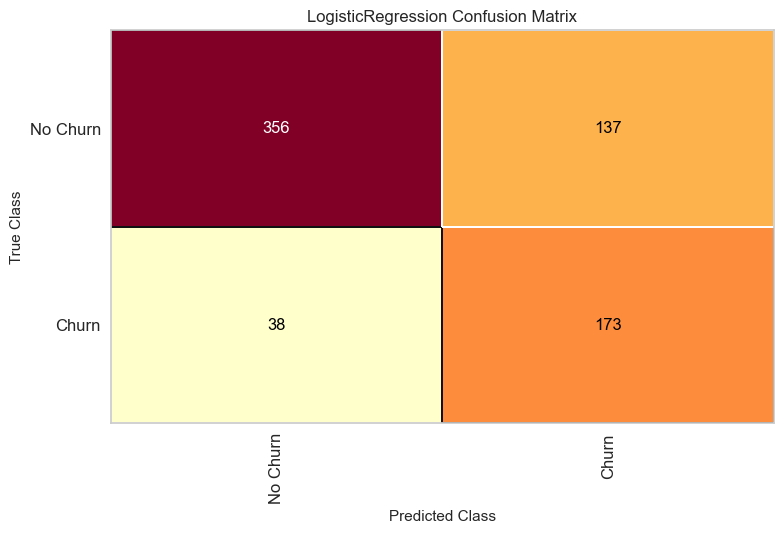

<Figure size 800x550 with 0 Axes>

In [12]:
# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

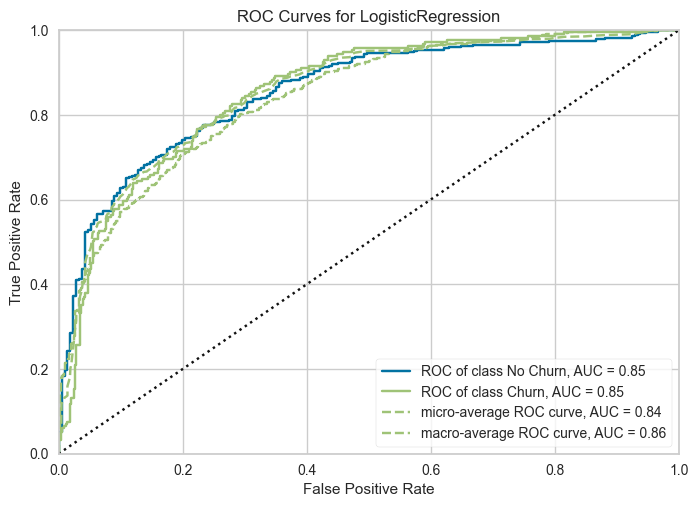

In [13]:
# # Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## Optimization
- GridSearchCV

In [14]:
param_grid = {'model__C': [0.1, 1, 10],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(model_pipe, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
0.806298901813285


In [30]:
model = LogisticRegression(C=10,
                           penalty = 'l1',
                           solver = 'liblinear',
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [31]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=300,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [32]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.778 STD: 0.08, AUC: 0.764
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       493
           1       0.55      0.82      0.66       211

    accuracy                           0.74       704
   macro avg       0.72      0.76      0.72       704
weighted avg       0.80      0.74      0.75       704



## Test

AUC: 0.743
              precision    recall  f1-score   support

           0       0.90      0.70      0.79       513
           1       0.50      0.79      0.61       192

    accuracy                           0.72       705
   macro avg       0.70      0.74      0.70       705
weighted avg       0.79      0.72      0.74       705



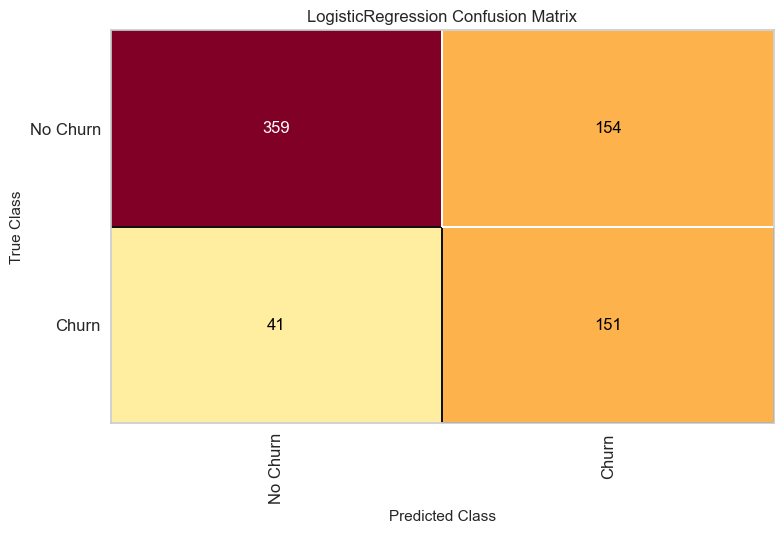

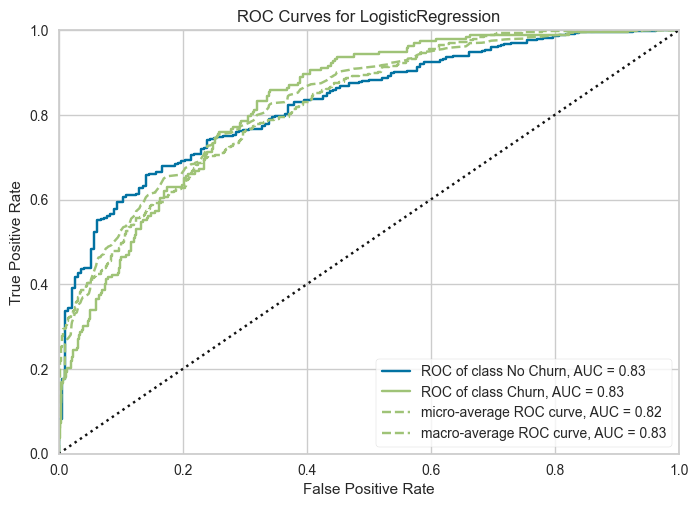

In [33]:
# Treina o modelo
model_pipe.fit(X_train, y_train)
# Faz predições
y_pred = model_pipe.predict(X_test)
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_test, y_pred)
#Exibe as métricas 
print(f"AUC: {auc:.3f}",end="\n")
print(classification_report(y_test, y_pred))

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Calculate ROI
- Calculate LTV estimated in period
- Estimate LTV max
- Calculate possible impact from machine learning

### LTV

In [34]:
# Calculate LTV based cust monthly by customer * tenure (monthly before of churn)
df_copy['LTV'] = df_copy['MonthlyCharges'] * df_copy['tenure']

In [35]:
# Value of LTV in the company
print(f'Total LTV actual: R${round(sum(df_copy["LTV"]),2) }')

Total LTV actual: R$16055091.45


In [36]:
# Estimate Max LTV (38) is tenure average if customer not churner
df_copy['LTV Max'] = df_copy.apply(lambda x: x['MonthlyCharges'] * x['tenure'] if x['Churn'] == 'No' else 38 * x['MonthlyCharges'], axis=1)

In [37]:
# Value of LTV in the company
print(f'LTV Max if Churn == 0!: R${round(sum(df_copy["LTV Max"]),2) }')

LTV Max if Churn == 0!: R$18479486.85


In [38]:
# If machine learning model is a sucess the difference is next:
print(f'R${round(sum(df_copy["LTV Max"] - df_copy["LTV"]),2)} ')

R$2424395.4 


### ROI Machine Learning
- To account for both model accuracy and model recall in financial earnings calculations, we can use the confusion matrix to estimate the costs and benefits of each type of classification (true positives, false positives, false negatives, and true negatives). From these values, we can calculate the expected value of lost revenue due to customer evasion and the expected financial gain with a given confidence interval.

In [39]:
def calcular_ganhos_financeiros(y_true, y_pred, custo_evasao, custo_aquisicao, custo_manutencao, numero_clientes_total):
    """
        calculate the expected value of lost revenue due to customer churn and the expected financial gain with a given confidence interval.

        Args:

            y_true (Series) - array of true classes in the data
            y_pred (Series) - array of predict classes from the model
            custo_evasao (float) - the financial cost to the company of losing a customer
            custo_aquisicao (float) - the financial cost for the company to acquire a new customer.
            custo_manutencao (float) - the financial cost for the company to retain a customer.
            numero_clientes_total (int) - the total number of customers in the company's database.

        Returns:
            ganho_esperado_min (float) - minimum impact financial
            ganho_esperado_max (float) - maximum impact financial
    """
    # Calcular a matriz de confusão do modelo
    matriz_confusao = cm(y_true, y_pred)

    # Calcular o número de clientes previstos pelo modelo para evadir e para ficar
    numero_clientes_evasao = matriz_confusao[1, :].sum()
    numero_clientes_ficar = matriz_confusao[0, :].sum()

    # Calcular o custo e benefício esperado de cada tipo de classificação
    custo_fp = custo_aquisicao * matriz_confusao[0, 1] / numero_clientes_total
    custo_fn = custo_evasao * matriz_confusao[1, 0] / numero_clientes_total
    beneficio_tp = custo_manutencao * matriz_confusao[0, 0] / numero_clientes_total
    beneficio_tn = 0

    # Calcular o valor esperado da receita perdida devido à evasão de clientes
    valor_esperado = custo_fn * numero_clientes_evasao

    # Calcular o intervalo de confiança das predições do modelo
    recall = matriz_confusao[1, 1] / (matriz_confusao[1, 1] + matriz_confusao[1, 0])
    recall_std = np.sqrt(recall * (1 - recall) / numero_clientes_total)
    intervalo_confianca = 1.96 * recall_std

    # Calcular o ganho financeiro esperado com 95% de confiança
    ganho_esperado_min = (beneficio_tp - custo_fp) * numero_clientes_ficar - intervalo_confianca * custo_fn * numero_clientes_evasao
    ganho_esperado_max = (beneficio_tp - custo_fp) * numero_clientes_ficar + intervalo_confianca * custo_fn * numero_clientes_evasao

    return ganho_esperado_min, ganho_esperado_max


## Deploy

In [24]:
with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
    joblib.dump(model_pipe, f)

In [25]:
with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
    model = joblib.load(f)

In [26]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', BinaryEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=300,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

# Test API server

In [27]:
import json
import requests

In [28]:
test_api = X_test.sample(2)
test_api = test_api.reset_index()

url = 'http://127.0.0.1:5000/predict'
request_data = json.dumps(test_api.to_dict(orient='records'))
header = {'Content-type': 'application/json' } 
response = requests.post(url, request_data, headers=header)
print(f'Status Code: {response.status_code}')
print(response.text)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000016F8315A080>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
result_api = response.json()
df_result = pd.DataFrame(result_api)

In [ ]:
df_result

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Prediction,Prescription
0,4732-RRJZC,No,Yes,Yes,7,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.25,144.35,0.28,No Potential Churn
1,8608-OZTLB,No,Yes,Yes,38,No,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,No,Electronic check,74.05,2802.30,0.14,No Potential Churn
